# Summoner Insights

**Author**: Alan Xia

**Website Link**: https://alanx1234.github.io/SummonerInsights/

In [37]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore", FutureWarning)

import plotly.express as px
pd.options.plotting.backend = 'plotly'


## Step 1: Introduction

### **Introduction**

League of Legends (LoL) is one of the world's most watched esports, bringing in millions of viewers across the globe every year. In addition, it has also consistently remained as one of the most popular games ever since its initial release in 2009. Each match is a thrilling 5-on-5 battle on Summoner's Rift, where each team tries to destroy the opposing Nexus in order to win. At the start of every game, players draft from a pool of over 150 unique champions and counting. League of Legends is deeply rooted in strategy and teamwork. Even before the game begins, each team has to strategically balance their champion picks across 5 different roles (top lane, jungle, mid lane, bot lane, and support) to not only synergize with each other but also counter the enemy team. When the game starts, players must farm minions and monsters to earn gold, which they can spend on items that make their champion stronger. Gaining control over neutral objectives on the map, such as dragons, Baron Nashor, and Rift Herald, can drastically swing the momentum of the game in favor of one team. The game only ends when one side's Nexus falls, regardless of how long the game takes.

League of Legends' competitive scene spans multiple regions, including LCK in Korea, LPL in China, LEC in Europe, LCS in America, and many more. All of these leagues eventually meet each year in the World Championship, which is an esports event watched by over 100 million at its peak. Each professional match generates a plethora of statistics, including kills, gold earned, objective control, vision score, and more, all of which influence coaches and analysts in shaping in-game tactics. By analyzing match-level statistics, we can attempt to deduce which in-game factors most strongly influence beating the other team. Understanding these factors holds potential for allowing teams to refine their gameplay, ranging from drafting champions to controlling the map, and ultimately gain a competitive edge through data-driven insights.

In this project, we analyze a season's worth of professional match data from Oracle's Elixir, which contains a total of 150,588 rows. Although the dataset includes a large variety of different in-game statistics, we will narrow our focus to only a subset of the available columns. Here is a brief description of the relevant columns for this analysis:

- `gameid`: Unique identifier for each match.
- `league`: The regional league in which the match was played.
- `position`: Role or lane played by the team or player (`top`, `jng`, `mid`, `bot`, `sup`, or `team` for aggregated data).
- `kills`: Number of enemy champions eliminated during the match.
- `assists`: Number of assists credited by participating in kills without getting the final blow.
- `deaths`: Number of times player (or team) was eliminated by enemy champions.
- `cspm`: Average creep score (minions killed) per minute.
- `monsterkills`: Total neutral monsters (jungle camps, monsters like Dragon or Baron) slain.
- `minionkills`: Total minions killed over the course of the game.
- `damagetochampions`: Total damage dealt to enemy champions during the match.
- `firstbaron`: Indicator (`1`/`0`) for if the team secured the first Baron Nashor kill.
- `dragons`: Total number of dragon kills secured during the match. 
- `result`: Match outcome (`1` = win, `0` = loss).

The main goal of this project will be to predict match outcome (`result`) using the in-game statistics listed above. Specifically, we will examine which of the following factors are the strongest predictors of a team's chance to win:
- individual performance (`kills`, `deaths`, `assists`, `cspm`, `damagetochampions`)
- objective control (`monsterkills`, `minionkills`, `firstbaron`, `dragons`)

To accomplish this, we will:
1. Clean and explore these columns to understand their individual distributions and pairwise relationships with `result`.
2. Perform hypothesis testing to examine missingness and evaluate key relationships in the data.
3. Train a classification model using these features to predict `result`.
4. Analyze the importance of each feature to identify which in-game factors are the best predictors of winning.

By the end of this analysis, we'll be able to determine which in-game metrics carry the most weight when predicting match outcomes in the professional League of Legends scene.


## Step 2: Data Cleaning and Exploratory Data Analysis

### **Data Cleaning**
To begin, we first filter the dataset to keep only the relevant columns. It is important to note that each game consists of 12 distinct observations — 2 for each team and 10 for each player. We want to model at the team level because it ensures that each row is an independent observation, rather than having the same `result` repeated five times. As a result, we should keep all rows where `position == 'team'` and discard all individual player rows. 

The original dataset also includes `datacompleteness`, which signifies if an observation has incomplete records or not. Since we require full entries for EDA and modeling, we should keep all rows where `datacompleteness` is `complete` to keep only team summaries with no missing values. Finally, we drop the position column as it becomes redundant.

In [38]:
df_raw = pd.read_csv('data/data.csv', low_memory = False)
df = df_raw[df_raw['datacompleteness'] == 'complete'].copy()
# filter dataframe for columns of interest
df = df[['gameid', 'league', 'position', 'kills', 'assists', 'deaths', 'damagetochampions', 'cspm', 'monsterkills', 'minionkills', 'firstbaron', 'dragons', 'result']]
# restrict dataframe to only 'team' entries
df = df[df['position'] == 'team'].drop(columns = 'position').reset_index(drop=True)
# display all columns
pd.set_option('display.max_columns', None)

df.head()

,gameid,league,kills,assists,deaths,damagetochampions,cspm,monsterkills,minionkills,firstbaron,dragons,result
0,ESPORTSTMNT01_2690210,LCKC,9,19,19,56560.0,29.4221,160.0,680.0,0.0,1.0,0
1,ESPORTSTMNT01_2690210,LCKC,19,62,9,79912.0,34.1856,184.0,792.0,0.0,3.0,1
2,ESPORTSTMNT01_2690219,LCKC,3,7,16,59579.0,34.3141,215.0,994.0,0.0,1.0,0
3,ESPORTSTMNT01_2690219,LCKC,16,39,3,74855.0,35.6764,244.0,1013.0,1.0,4.0,1
4,ESPORTSTMNT01_2690227,LCKC,14,42,5,67376.0,34.7769,269.0,874.0,1.0,4.0,1


We then convert each column to its proper type:
- `league` -> **categorical**
- `cspm` -> **float**
- `firstbaron`, `result` -> **bool**
- `kills`, `assists`, `deaths`, `damagetochampion`, `monsterkills`, `minionskills`, `dragons` -> **int**

Here is a preview of the fully cleaned team‐level data:

In [39]:
# convert columns to proper types
df['league'] = df['league'].astype('category')
df['cspm'] = df['cspm'].astype(float)
df['firstbaron'] = df['firstbaron'].astype(bool)
df['result'] = df['result'].astype(bool)

# convert all int columns
for col in  ['kills','assists','deaths','damagetochampions','dragons']:
    df[col] = df[col].astype(int)
df.head()

,gameid,league,kills,assists,deaths,damagetochampions,cspm,monsterkills,minionkills,firstbaron,dragons,result
0,ESPORTSTMNT01_2690210,LCKC,9,19,19,56560,29.4221,160.0,680.0,False,1,False
1,ESPORTSTMNT01_2690210,LCKC,19,62,9,79912,34.1856,184.0,792.0,False,3,True
2,ESPORTSTMNT01_2690219,LCKC,3,7,16,59579,34.3141,215.0,994.0,False,1,False
3,ESPORTSTMNT01_2690219,LCKC,16,39,3,74855,35.6764,244.0,1013.0,True,4,True
4,ESPORTSTMNT01_2690227,LCKC,14,42,5,67376,34.7769,269.0,874.0,True,4,True


### **Univariate Analysis**

Before proceeding with any further analysis, let's first take a look at some of our variable of interests on their own. In doing so, we can get a better intuition of how some of our variables are distributed. We can examine the individual distributions for `kills` and `cspm`, which will help us understand their spread, skew, outliers, and whether or not any transformations may be needed during the modeling process or during hypothesis testing. 

In [40]:
fig = px.histogram(
    df,
    x="kills",
    nbins=20,
    color_discrete_sequence=["#9457EB"],
    title="Distribution of Total Kills",
    labels={"kills":"Kills"},
    
)
fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width= 1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)
fig.show()

In [41]:
fig = px.histogram(
    df,
    x="cspm",
    color_discrete_sequence=["#9457EB"],
    nbins=30,
    title="Distribution of Creep Score per Minute",
    labels={"cspm":"Creep Score per Minute"},
)
fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width= 1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False) 
)

fig.show()

**Total Team Kills**

The kills histogram is right-skewed, showing that teams typically have between 5 and 25 kills in the majority of professional matches . Most of the distribution lies in this range, but a few high-kill games surpass the 30 kill mark. In this distribution, the median is a more robust measure of center than the mean. The median kill count sitting at around 15 tells us that half of all matches have fewer than 15 kills and half have more, which gives us a clearer sense of how most games play out. In practice, applying a log-transform could help reduce the influence of extreme outliers when modeling. While games with low kill counts might indicate a slow paced game, ones with high kill counts could be attributed to brawl-heavy matches where fights take priority over other aspects of the game.

**Team Creep Score per Minute**

The Creep Score per Minute (CSPM) histogram is symmetric, with a peak at around 30-32 CS per minute. This implies that most matches in the professional scene feature a consistent rate of farming minions, and there are typically few extreme outliers. Because there is hardly any skew present, the mean and median the distribution are roughly the same. All of these features imply that CSPM is roughly normal, which means that using z-score for standardization is appropriate. Low CSPM might reflect games where teams played more aggressively rather than defensively, constantly engaging in team fights and skirmishes, while high CSPM suggests the opposite.

### **Bivariate Analysis**

Now that we have examined some individual distributions, we can now transfer our attention to analyzing the relationships between variables. In the univariate analysis step, we made observations of how CSPM and kills are individually distributed, and we can now extend that in this step. By plotting CSPM against kills and comparing damage output in wins versus losses, we can get a general idea of which variables are correlated. The insights gained here will be helpful in conducting hypothesis tests and our modeling process down the line.

In [42]:
corr = round(df['cspm'].corr(df['kills']),3)
fig = px.scatter(
    df,
    x="cspm",
    y="kills",
    color_discrete_sequence=["#9457EB"],
    opacity=0.7,
    labels={"cspm":"Creep Score per Minute", "kills":"Kills "},
    title=f"CSPM vs. Kills (r = {corr})"
)
fig.update_traces(
    marker={"size": 4, "opacity": 0.6}
)
fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width= 800,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)
fig.show()

In [43]:
fig = px.box(
    df,
    x="result",
    y="damagetochampions",
    color_discrete_sequence=["#9457EB"],
    points = False,
    labels={
        "result": "Game Result",
        "damagetochampions": "Damage to Champions"
    },
    title="Damage to Champions in Wins vs. Losses"
)
fig.update_xaxes(tickvals=[False, True], ticktext=["Loss","Win"])
fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width=800,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)
fig.show()

**CSPM vs. Kills**

The scatterplot shows no consistent trends, with the points forming a cloud-like shape. The Pearson correlation coefficient r comes out to be almost 0.00, so there is clearly no linear association between CSPM and kills. We see plenty of games where teams had high CSPM with low kills, and vice versa. This might seem counterintuitive as it might be expected that higher CSPM would correlate with higher kills, as having more gold would mean that you can purchase more items to enhance your champion's power. However, in the context of professional League of Legends, almost every player can consistently maintain a high CSPM, so this statistic mainly reflects the overall tempo and pacing of the game such as if there are frequent brawls or if farming becomes the priority. This highlights an important confound, which shows that the pace of the game can serve as a major determinant of CSPM. In contrast, in the casual world of League of Legends, CSPM might depend more on the player's ability to consistently farm and their mechanics.


**Damage to Champions vs Game Result**

The boxplot shows the trend that more damage is dealt in wins compared to losses. While the median damage is about 55,000 in losses, it reaches nearly 70,000 in wins. Interestingly, the upper whisker (about 225,000) for losses is slightly higher than the one for wins (about 200,000), showing that games with very high total damage output don't necessarily always translate to wins. It's important to note that in League of Legends, dealing a lot of damage to champions doesn't guarantee kills, as damage can be mitigated by shields or healing. Additionally, poor target selection, such as targeting champions that have higher health, can artificially inflate the total damage. Without properly securing kills, high damage itself won't always translate to wins.

### **Interesting Aggregates**



Here is a table showing the average damage output and kills in losses versus wins for each of the top five leagues by total games:

In [44]:
# show top 5 leagues by game count
df5 = df[df['league'].isin(df['league'].value_counts().nlargest(5).index)]

# pivot table displaying the average damage to champions and kills in losses vs. wins
pivot = pd.pivot_table(
    df5,
    index='league',
    columns='result',                
    values=['kills','damagetochampions'],
    aggfunc='mean',
    observed = True
).round(1)

# rename columns for clarity
pivot = pivot.rename(columns={False: "Loss", True: "Win"}, level=1)
pivot

damagetochampions          kills      
result              Loss      Win  Loss   Win
league                                       
LCK              57408.3  71721.1   7.2  15.9
LCKC             59923.0  71999.2   8.7  17.6
LCSA             62443.8  76880.0   9.5  19.6
PGC              61643.7  75464.8  11.6  22.9
UPL              64438.9  78961.4  13.3  25.2

Across these top five leagues in the world, both average kills and average damage are higher in wins compared to losses. While the difference in damage in losses and wins is more subtle, there is a drastic difference in the average amount of kills in losses and in wins. The magnitude of these differences also vary by region. For example, while PGC shows an 11.3 kill increase in wins compared to losses, LCKC only has an 8.9 kill difference. These differences could be attributed to the different playstyles and approaches to the game specific to each region. Regardless, the consistent pattern confirms that both damage to champions and kill count can serve as reliable indicators of winning regardless of what league we are analyzing.

## Step 3: Assessment of Missingness

### **NMAR Analysis**

Before proceeding to draft our baseline predictive model, we turn our attention towards assessing missingness in our dataset. As none of the columns we are interested in are NMAR, we zoom back out to the scope of the entire raw dataset.

In particular, we can observe that the `ban1` column (and by extension, any of the `ban` columns) is NMAR, as its missingness is directly tied to the missing value itself. In the snippet below showing a game played in PGC, you can see that for this specific team, `ban1`, `ban2`, and `ban3` are missing while `ban4` and `ban5` are populated. In this case, the tournament this game took place in may have only allowed two bans per side as opposed to five, where missing bans are represented with NaNs. 

In [45]:
df_raw[df_raw['ban1'].isna()][['gameid', 'league', 'datacompleteness','position', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']].head()

,gameid,league,datacompleteness,position,ban1,ban2,ban3,ban4,ban5
425,NA1_4171105636,PGC,complete,top,NaN,NaN,NaN,Lux,LeBlanc
426,NA1_4171105636,PGC,complete,jng,NaN,NaN,NaN,Lux,LeBlanc
427,NA1_4171105636,PGC,complete,mid,NaN,NaN,NaN,Lux,LeBlanc
428,NA1_4171105636,PGC,complete,bot,NaN,NaN,NaN,Lux,LeBlanc
429,NA1_4171105636,PGC,complete,sup,NaN,NaN,NaN,Lux,LeBlanc


If we wanted to convert this into a Missing at Random (MAR) scenario, we could add a new column called `num_bans` to explain the missingness of `ban1`. This new column denotes the number of bans allowed for a specific match, so the missingness of `ban1` would become MAR instead of NMAR because it would depend on `num_bans`. In contrast, without this column in our original raw dataset, the ban slots are clearly NMAR because their missingness depends on unobserved tournament rules.

### **Missingness Dependency**

For the remainder of this missingness analysis, we'll continue to work with the unfiltered raw dataset so that all missing values are still present. However, we will narrow our focus to the columns we are interested in. First, we'll examine a column with non-trivial missingness to analyze, and then perform permutation tests to see if the missingness is dependent on other columns. We will analyze whether or not the missingness of `cspm` depends on other columns through hypothesis testing, using a significance level of  **0.05** to indicate statistical significance.

#### CSPM vs. League

**Null Hypothesis**: The distribution of `league` is the same whether `cspm` is missing or not. Any observed differences can be attributed to random chance.

**Alternative Hypothesis**: The distribution of `league` differs between rows where `cspm` is missing and rows where `cspm` is observed. Any observed differences cannot be attributed to random chance.

**Test Statistic**: Total Variation Distance (TVD).

Below, we display the first few rows of the observed distribution of `league` depending on whether `cspm` is missing or not. We proceed to conduct the permutation test over 1,000 repetitions.

In [46]:
df_mar = df_raw.copy()

# build pivot table counting rows per league and missingness
obs_dist = (
    df_mar
    .assign(cspm_missing = df_mar['cspm'].isna())
    .pivot_table(index = 'league', columns = 'cspm_missing', aggfunc = 'size', fill_value = 0)
)
# rename columns for clarity
obs_dist.columns = ['cspm_missing = False', 'cspm_missing = True']
# normalize by column
obs_dist = obs_dist / obs_dist.sum()
obs_dist.head()

,cspm_missing = False,cspm_missing = True
league,,
ASCI,0.005041,0.039091
CBLOL,0.019863,0.000000
CBLOLA,0.017656,0.000000
CDF,0.006212,0.000000
CT,0.002125,0.000000


In [47]:
def tvd(df):
    # computes tvd given pivot table
    diffs = df.diff(axis=1).abs().iloc[:, 1]
    return diffs.sum() / 2

shuffled = df_mar.copy()

# initialize column for detecting missingness in cspm
shuffled['cspm_missing'] = shuffled['cspm'].isna()
observed = tvd(obs_dist)

tvds = []
for _ in range(1_000):
    # shuffle label
    shuffled['cspm_missing'] = np.random.permutation(shuffled['cspm_missing'])
    
    pos_dist = (
        shuffled
        .pivot_table(index = 'league', columns = 'cspm_missing', aggfunc = 'size', fill_value = 0)
    )
    # normalize by column
    pos_dist = pos_dist / pos_dist.sum()
    # compute tvd for this sample
    tvds.append(tvd(pos_dist))

p_value = np.mean(tvds >= observed)
p_value

np.float64(0.0)

In [48]:
fig = px.histogram(
    x=tvds,
    nbins=30,
    histnorm="probability",
    color_discrete_sequence=["#9457EB"],    
    labels={"x":"Total Variation Distance (TVD)", "y":"probability"},
    title="Empirical Distribution of TVD Under Null"
)
fig.add_vline(
    x=observed,
    line_dash="dash",
    line_color="#FF7F0E",                     
    name = "Observed",
    showlegend = True
)

fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width=1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)

fig.show()

**Interpretation**

After conducting the permutation test, we see that our observed TVD of 0.865 lies far beyond the right tail of the empirical distribution under the null (p = 0.00). Therefore, we reject the null hypothesis that the missingness of `cspm` is independent of `league`. In other words, `cspm` is not MCAR because its probability of being missing varies depending on the league or region the game was played in. This means that `cspm` is MAR when conditioned on `league`.

Next, we can proceed to look at a column that the missingness of `cspm` does depend on.

#### CSPM vs Result

**Null Hypothesis**: The distribution of `result` is the same whether `cspm` is missing or not. Any observed differences can be attributed to random chance.

**Alternative Hypothesis**: The distribution of `result` differs between rows where `cspm` is missing and rows where `cspm` is observed. Any observed differences cannot be attributed to random chance.

**Test Statistic**: Total Variation Distance (TVD).

Similarly, we display the first few rows of the observed distribution of `result` depending on whether `cspm` is missing or not. Naturally, this will flow very similarly to the prior permutation test as we are comparing two categorical distributions in both. We then do a permutation test over 1,000 repetitions.

In [49]:
df_mcar = df_raw.copy()

# pivot table of raw counts for wins/losses for when cspm is missing v. not missing
obs_dist = (
    df_mcar
    .assign(cspm_missing = df_mcar['cspm'].isna())
    .pivot_table(index = 'result', columns = 'cspm_missing', aggfunc = 'size', fill_value = 0)
)
# rename for clarity
obs_dist.columns = ['cspm_missing = False', 'cspm_missing = True']

# normalize by column
obs_dist = obs_dist / obs_dist.sum()
obs_dist

,cspm_missing = False,cspm_missing = True
result,,
0,0.5,0.5
1,0.5,0.5


In [50]:
def tvd(df):
    # computes tvd given a pivot table
    diffs = df.diff(axis=1).abs().iloc[:, 1]
    return diffs.sum() / 2

shuffled = df_mcar.copy()

# initialize column for detecting missingness in cspm
shuffled['cspm_missing'] = shuffled['cspm'].isna()
observed = tvd(obs_dist)

tvds = []
for _ in range(1_000):
    # shuffle label
    shuffled['cspm_missing'] = np.random.permutation(shuffled['cspm_missing'])
    # pivot table of raw counts for wins/losses for when cspm is missing v. not missing
    pos_dist = (
        shuffled
        .pivot_table(index = 'result', columns = 'cspm_missing', aggfunc = 'size', fill_value = 0)
    )
    # normalize by column
    pos_dist = pos_dist / pos_dist.sum()
    # compute tvd for this sample
    tvds.append(tvd(pos_dist))

p_value = np.mean(tvds >= observed)
p_value

np.float64(1.0)

In [51]:
fig = px.histogram(
    x=tvds,
    nbins=30,
    histnorm="probability",
    color_discrete_sequence=["#9457EB"],      
    labels={"x":"Total Variation Distance (TVD)", "y":"probability"},
    title="Empirical Distribution of TVD Under Null",
)

fig.add_vline(
    x=observed,
    line_dash="dash",
    line_color="#FF7F0E",                     
    name = "Observed",
    showlegend = True
)

fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width=1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)

fig.show()

**Interpretation**

We see that every simulated TVD in our empirical distribution is larger than or equal to our observed TVD of 0.00, which indicates a p-value of 1.00. Therefore, we fail to reject the null hypothesis that missingness of `cspm` is independent of `result`. There is no evidence that the missingness of `cspm` depends on `result` based on this permutation test.

In this section, we have shown that the chance `cspm` is missing differs by `league`, but does not vary with `result`. Since its missingness is tied to another observed variable (`league`), we conclude that `cspm` is MAR. This would be useful to know if we wanted to perform imputation, but our current analysis already filters out any missing values using the `datacompleteness` column.

With these preliminary steps being taken, we are free to start to move on to our main analysis.

## Step 4: Hypothesis Testing

### **Hypothesis Testing**

Now that we've performed exploratory data analysis and characterized some of the missingness in our data, we can turn our attention towards answering the questions we really care about. In this section, we will perform another hypothesis test on our dataset — this time not to test missingness —  as a preliminary to building a predictive model. Because each kill that a team secures throughout a match is highly impactful, it makes sense to start by examining the relationship between kills and match outcome. In the following hypothesis test, we will investigate if the number of kills that a team records differs between matches they win versus matches they lose. Specifically, we will test the following pair of hypotheses:

**Null Hypothesis**: The distribution of `kills` in losses and wins are the same, and any observed differences can be attributed to random chance.

**Alternative Hypothesis**: The distribution of `kills` in losses and wins are **not** the same, and any observed differences cannot be explained by random chance.

**Test Statistic**: Absolute difference in means.

We can use the absolute difference in means as the test statistic based on the KDE plot below depicting the distribution of kills in wins and losses. Both distributions have similar shapes and their variances are almost identical (wins: 32.02, losses: 30.49), so they are essentially shifted versions of each other. This implies that we do not need to use the Kolmogorov-Smirnov test statistic because the centers of the two distributions are relatively spread apart. The absolute difference in means is ideal in this scenario, and reflects the alternative hypothesis since it will detect any differences in the means of the two distributions regardless of directionality. 

In [52]:
# filter df for wins and losses
wins   = df.loc[df["result"], "kills"]
losses = df.loc[~df["result"], "kills"]

# make grid span from min to max kills value
x_min, x_max = df["kills"].min(), df["kills"].max()
x_grid = np.linspace(x_min, x_max, 200)

# fit kdes for wins and losses
kde_win   = gaussian_kde(wins)
kde_loss  = gaussian_kde(losses)
dens_win  = kde_win(x_grid)
dens_loss = kde_loss(x_grid)

# combine into a single df
df_kde = pd.DataFrame({
    "kills":   np.concatenate([x_grid, x_grid]),
    "density": np.concatenate([dens_win, dens_loss]),
    "Outcome": ["Win"] * len(x_grid) + ["Loss"] * len(x_grid)})

fig = px.line(
    df_kde,
    x="kills",
    y="density",
    color="Outcome",
    color_discrete_map={"Win":  "#9457EB", "Loss": "#FF7F0E"},
    labels={"kills": "Kills", "density": "Density"},
    title="Distribution of Kills in Wins vs. Losses",
)

fig.update_layout(
    paper_bgcolor="#F7F7F7",    
    width=1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,                 
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    legend=dict(
        title="", 
        orientation="h", 
        yanchor="bottom", 
        y=1.02, 
        xanchor="right", 
        x=1
    ),
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        title_font=dict(size=14),
        tickfont=dict(size=14)
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        title_font=dict(size=14),
        tickfont=dict(size=14)
    )
)
fig.show()

var_wins   = wins.var()
var_losses = losses.var()
print(f"Variance in wins:  {var_wins:.2f}")
print(f"Variance in losses: {var_losses:.2f}")

Variance in wins:  32.02
Variance in losses: 30.49


Under the assumption of the null, we can permute the `result` column, calculate the resulting absolute difference in average kills, and then compare our observed difference to this null distribution to obtain a p-value. If very few empirical differences end up being greater than or equal to the observed value, we can reject the null and infer that the average kills differ in wins versus losses. Otherwise, we fail to reject the null. Note that neither of these conclusions are definitive, since statistical tests alone cannot prove that either hypothesis is entirely true or false.

We proceed to test these hypotheses via a permutation test over 1,000 trials, using a significance level of 0.05 to indicate statistical significance.

In [53]:
# filter for kills in wins vs. losses
wins   = df.loc[df['result'], 'kills']
losses = df.loc[~df['result'], 'kills']

# compute observed difference in means
observed = abs(wins.mean() - losses.mean())

diffs = []

for _ in range (1_000):
    # shuffle result column to simulate the null
    shuffled = df.assign(shuffled_result = np.random.permutation(df['result']))
    
    wins = shuffled.loc[shuffled['shuffled_result'], 'kills'].mean()
    losses = shuffled.loc[~shuffled['shuffled_result'], 'kills'].mean()
    # compute diffs in means and add
    diffs.append(abs(wins - losses))

p_value = np.mean(diffs >= observed)
p_value

np.float64(0.0)

In [54]:
fig = px.histogram(
    x= diffs,
    nbins=30,
    histnorm="probability",
    color_discrete_sequence=["#9457EB"], 
    labels={"x":"Absolute Difference in Means", "y":"Density"},
    title="Absolute Difference in Means Under Null"
)
fig.add_vline(
    x=observed,
    line_dash="dash",
    line_color="#FF7F0E",                     
    name = "Observed",
    showlegend = True
)

fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width=1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)

fig.show()


**Conclusion**

The p-value we obtained, 0.00, is far below the significance level threshold of 0.05. We also see that roughly none of the simulated test statistics under the null are greater than or equal to the observed test statistic. Therefore, we reject the null hypothesis and conclude that there is strong statistical evidence in favor of the alternative hypothesis. This suggests that teams record a different average number of kills in wins versus losses. Again, it is important to note that we cannot fully prove this difference just by using statistical tests, but our permutation test allows us to conclude that a gap of roughly 10 kills in wins versus losses is highly unlikely to occur if winning or losing had no effect on kill counts. 

By previewing which statistics might have an impact on match outcome, the insights gained from this hypothesis test will be helpful for building our predictive model going forth.

## Step 5: Framing a Prediction Problem

### **Problem Identification**

For the remainder of this project, we will pivot our focus towards building a predictive model. 

We will build a binary classification model to predict whether a team wins or loses based on the remaining columns in our filtered dataset. The response variable is `result`, where `True` corresponds to winning and `False` corresponds to losing. I chose this response variable because being able to accurately predict the outcome of a match can offer great insights for e-sports teams, coaches, analysts, and even fans who play the game casually like myself. Knowing which factors are most essential to winning can help shape gameplay tactics and allow for a deeper understanding of the game. 

In the Exploratory Data Analysis step, we filtered our dataset to only include team-aggregated data. The reasoning behind this is that as mentioned before, a single match generates 12 observations in our dataset. Two of these correspond to team-aggregated data for each team, while the remainder of these observations correspond to individual players. For instance, if we only kept the player-level rows, one team winning would appear as five separate observations with `result` as `True`, despite the fact that not every player equally contributes to the victory. On the other hand, keeping only the rows representing team-aggregated data mitigates this issue, and also ensures that our observations are independent from each other, which is ideal for minimizing model bias and variance.

For evaluation metrics, we will use **accuracy** to calculate the percentage of matches the model predicts correctly, and **F1 score** to preserve a balance between recall and precision. I chose accuracy because wins and losses are naturally roughly equal in the dataset, so it would be a simple measure of correctness overall. I chose F1 score because it is able to consider both false positives and false negatives, so that we don't have to use recall or precision separately.

Because we are using full match summary stats, we can assume all of our features are available at the time of prediction. Essentially, we are building a classifier that uses metrics recorded at the end of games to explain why a team won or lost.

## Step 6: Baseline Model

#### **Baseline Model**

For our baseline classifier, we will train a `RandomForestClassifier` and start with only two features: `kills` and `firstbaron`. We will examine the extent to which a simple model like this which uses one quantitative feature (`kills`) and one nominal feature (`firstbaron`) can be used to accurately predict `result`. Despite the simplicity of this model, overall kill count and securing the first baron are both essential to winning. If the performance of this model is already good, then we know that these two features alone can be effective in predicting match outcome. On the other hand, if we conclude that the performance is poor, then we'll know that adding more features is probably needed. Regardless of the initial performance, we'll be making many improvements in our final model.

To begin, we'll use an 80/20 train-test split so that 20% of the matches in our dataset are used for evaluation. This helps ensure that our model is able to generalize to data that it hasn't trained on, which gives us a good idea of how it will perform for unseen games. Next, we will one-hot encode `firstbaron` so that it becomes a binary indicator and leave `kills` unchanged. Then, we build a pipeline to preprocess our features and initialize a `RandomForestClassifier` simultaneously. 

In [55]:
# select first two features and target
X = df[['kills' , 'firstbaron']]
y = df['result']

# train test split (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# one-hot encode firstbaron
preproc = ColumnTransformer(
    [('ohe_firstbaron', OneHotEncoder(drop="if_binary"), ['firstbaron'])], # only keep one column to represent both states
    remainder = 'passthrough',
    force_int_remainder_cols=False, # keep original dtypes
)

# build pipeline
pl = make_pipeline(
    preproc,
    RandomForestClassifier(random_state = 1)
)
pl

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe_firstbaron',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['firstbaron'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])

Finally, we fit the pipeline, display a confusion matrix, and evaluate our predictions on the test set using the specified metrics: accuracy and F1 score.

Test set accuracy: 0.881
Test set F1 score: 0.884


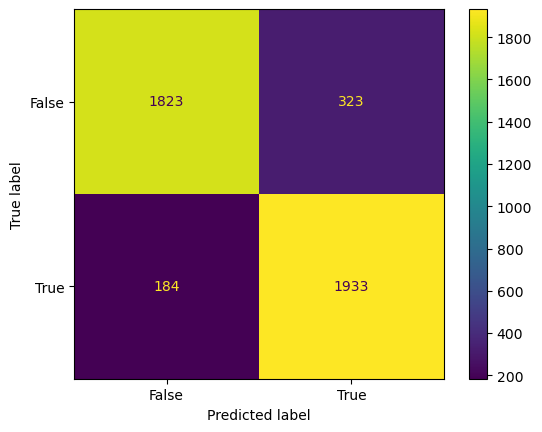

In [56]:
# fit on the train dataset, then predict on the test set
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

# evaluate using specified metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# display confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(pl, X_test, y_test);
plt.grid(False)

print(f"Test set accuracy: {accuracy:.3f}")
print(f"Test set F1 score: {f1:.3f}")

**Evaluation**

Our baseline model was able to achieve an accuracy of 88.1% and an F1 score of 0.884. This means that for example, if we were trying to predict the outcome of 1,000 matches just using the features `kills` and `firstbaron`, we would classify about 881 of them correctly. This is impressive for a baseline model! As mentioned before, since the number of wins and losses in our dataset are about the same, accuracy gives us a good sense of the correctness of our model. Since the F1 score is the harmonic mean of precision and recall, an F1 score of 0.884 tells us that the model has a good balance between the two, meaning it does well to minimize false positives (predicting a win when the team lost) and false negatives (predicting a loss when the team won). We can confirm this by looking at the confusion matrix and noting that there were far more true positives than false positives, and far more true negatives than false negatives.

With a baseline model that already exhibits relatively strong performance, it's time to upgrade it even further in the next section.

## Step 7: Final Model

#### **Final Model**

In this section, we'll construct a final model that improves up on our baseline model that used two features. To do so, we will do the following:

1. **Feature Engineering**: Engineer at least two new features from our variables of interest.
2. **Hyperparameter Search**: Perform a hyperparameter search using `GridSearchCV` to find the best hyperparameters for `RandomForestClassifier`.

**Feature Engineering**

In addition our baseline features (`kills` and `firstbaron`), we will add a total of three new features.

1. `KDA` (`kills`, `deaths`, and `assists`) 

This is calculated as the sum of a player's kills and assists divided by their total deaths (by 1 if they had zero deaths). Although this is typically used for individual players, we can calculate this for the entire team's stats as well. The reason behind adding this feature is that it combines `kills`, `assists`, and `deaths` into a single metric, allowing us to capture both offensive contribution and survivability at once. Even though we already have `kills` as a feature, classifiers like `RandomForestClassifier` are typically not as sensitive to collinearity between features as opposed to a linear model.

2. `cspm` 

Because CSPM is an excellent indicator of a team's resource levels and overall strength in the later stages of the game, it serves as a great feature to add to our model. Naturally, a higher CSPM means that a team has more gold available to buy stronger items throughout the game. In a similar line of reasoning to K/DA, CSPM also effectively captures `monsterkills` and `minionkills` since these are directly calculated in CSPM.

3. `dragons`

Like baron, the different types of dragons in the game offer immense powerups to a team when they secure them. As such, they can serve as powerful predictors of match outcome. We will interpret `dragons` as a numeric variable as opposed to a categorical ordinal variable due to how Random Forests can naturally recognize that teams with higher dragon counts tend to win, without needing to explicitly define categories.

Because Random Forests are tree-based, they don't require numeric features to be on the same scale. As a result, applying a `StandardScaler` to columns like `kills`, `KDA`, `cspm`, and `dragons` isn't necessary in the context of this analysis. We will skip this step and leave these numeric features in their raw form. Like the baseline model, we will only preprocess `firstbaron` by one-hot encoding it using `ColumnTransformer`.

In [66]:
# compute KDA as the sum of kills and assists divided by deaths
df['KDA'] = np.round((df['kills'] + df['assists']) / df['deaths'].replace(0, 1), 2 )

X = df[['kills', 'firstbaron', 'KDA', 'cspm', 'dragons']]
y = df['result']

# one-hot encode firstbaron
preproc = ColumnTransformer(
    [('ohe_firstbaron', OneHotEncoder(drop="if_binary"), ['firstbaron'])], # only keep one column to represent both states
    remainder = 'passthrough',
    force_int_remainder_cols=False, # keep original dtypes
)

**Hyperparameter Search**

We will perform a hyperparameter search using `GridSearchCV` to find the optimal combination of hyperparameters for each tree so that the forest isn't underfitting nor overfitting. Our goal is to minimize both the bias and the variance of our model so that it generalizes well to unseen data. Using 5-fold cross validation in our grid search will help with this as it makes sure that each combination of hyperparameters is tested on different subsets of the training data. In particular, we'll take a look at the following following hyperparameters:
- `n_estimators`: The number of trees in the forest. Not enough trees could result in high variance, while too many trees could slow down training.
- `max_depth`: The maximum depth of each tree. Lower depth might reduce overfitting, while higher depth allows for greater complexity.
- `min_samples_leaf`: The minimum number of samples required for creating a leaf. Requiring more samples will generally reduce overfitting.
- `min_samples_split`: The minimum number of samples required to split an internal node. Requiring more samples will generally reduce overfitting.
- `criterion`: The function used for evaluating splits. Different criteria can result in different trees, so we will see which one generalizes better.

In [67]:
# train test split (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1
)

# build pipeline
pl = make_pipeline(
    preproc,
    RandomForestClassifier(random_state = 1)
)
# initialize hyperparameters to test
hyperparameters = {
    "randomforestclassifier__n_estimators":    [100, 300, 500],
    "randomforestclassifier__max_depth":       [None, 5, 15],
    "randomforestclassifier__min_samples_split":[2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [2, 3, 5],
    "randomforestclassifier__criterion":       ["gini", "entropy"]
}

searcher = GridSearchCV(
    pl,
    param_grid = hyperparameters,
    cv = 5
)
# fit searcher on training data to find best hyperparameter combination
searcher.fit(X_train, y_train)

# display best parameters
best_params = searcher.best_params_
best_params

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 300}

The results of this grid search show that the optimal combination of parameters for `RandomForestClassifier` is:

- **n_estimators** = 300
- **max_depth** = 5
- **min_samples_leaf** = 2
- **min_samples_split** = 5
- **criterion** =  `gini`

Next, we will build a final pipeline using these hyperparameters, fit it on the entirety of the training data, and then evaluate and compare its performance to the baseline model.

Test set accuracy: 0.955
Test set F1 score: 0.955


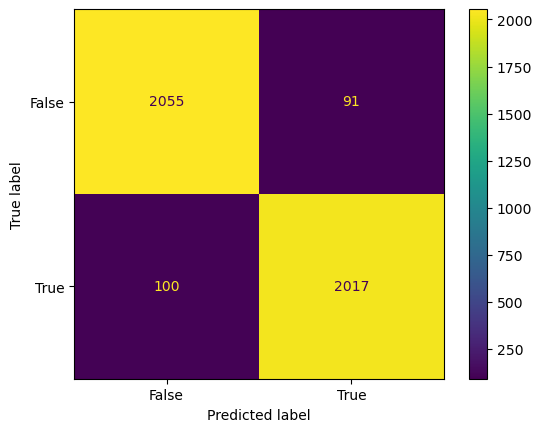

In [69]:
# build finalized pipeline
final_pl = make_pipeline(
    preproc,
    RandomForestClassifier( # from grid search
        n_estimators = 300,
        max_depth = 5, 
        min_samples_leaf = 2, 
        min_samples_split = 5, 
        criterion = 'gini', 
        random_state = 1
    )
)

final_pl.fit(X_train, y_train)
y_pred = final_pl.predict(X_test)

# evaluate using specified metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# display confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(final_pl, X_test, y_test);
plt.grid(False)

print(f"Test set accuracy: {accuracy:.3f}")
print(f"Test set F1 score: {f1:.3f}")

**Evaluation**

Our improved version of the baseline model achieves an accuracy of 95.5% and an F1 score of 0.955. Note that because we used `random_state = 1` to split both the baseline and final data sets, both models were trained on exactly the same 80% of rows and evaluated on the same remaining 20%. As a result, we are able to directly compare the evaluation metrics produced in the final model to the ones in the baseline model. Overall, this is a significant improvement over the baseline model. By adding the features `cspm`, `KDA`, and `dragons`, and by performing a hyperparameter search using `GridSearchCV`, we were able to improve both the overall correctness of the model as well as its balance between precision and recall. 

Looking at the confusion matrix for the final model, we see that there were only 91 false positives, where losses were predicted as wins, and 100 false negatives, where wins were predicted as losses. In contrast, the baseline had 323 false positives and 184 false negatives. This is a drastic improvement when it comes to minimizing these two types of errors.

This confirms that the addition of these new features plus hyperparameter tuning have greatly improved the predictive power of our model. 

The table below shows each feature's relative importance in our finalized Random Forest model.

In [60]:
# save final model
rf = final_pl.named_steps['randomforestclassifier']

# extract feature importances
feature_names = ['firstbaron', 'kills', 'KDA', 'cspm', 'dragons']
importances = rf.feature_importances_

# make a df for clarity
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_importance_df

,feature,importance
0,KDA,0.593714
1,kills,0.188146
2,firstbaron,0.154173
3,dragons,0.044671
4,cspm,0.019296


**Feature Importance**

First, it's important to note that since `KDA` and `kills` are correlated because `KDA` is directly constructed from `kills`, this means their importance scores may get shared when the forest is training. This doesn't necessarily hurt the performance of the model, but it could lower each feature's importance score. Regardless, we can still examine each feature’s relative importance to some extent.

We see that `KDA`, a mixture between `kills`, `deaths`, and `assists`, turns out to be the most important feature for predicting the outcome of a match. A team having a high KDA greatly influences the model into predicting a victory. This is intuitive because maximizing kills and assists and minimizing deaths is the most effective way of building a resource and experience advantage, which can be a decider in major fights throughout the game. 

The next two most important features are `kills` and `firstbaron`. Seeing `kills` rank in second place also makes sense, as it directly contributes to `KDA`. Surprisingly, with how prevalently teams strategize to seize the first baron, it has relatively low importance in comparison to `KDA`. Despite this, it still carries a considerable amount of predictive power.

The two least important features are `dragons` and `cspm`. It is intuitive for `dragons` to be less influential in comparison to `firstbaron`, as Baron Nashor offers a much stronger buff when secured. However, it is somewhat surprising that `cspm` contributes so little to the model's predictions, even though farming minions and jungle monsters are the main ways players gain gold, aside from kills and assists. But as noted before, almost every player at the professional level is capable of consistently obtaining high CSPM. Rather, it is the tempo of the game that dictates how high a team's overall CSPM is. We saw glimpses of this in our univariate analysis step, where we noted that there is essentially no correlation between `cspm` and `kills`.

**Takeaways**

We can translate these findings directly to three main areas of focus for coaches and players:

1. **Maximize Overall KDA**

With how important KDA is in predicting match outcome, it should be a team's number one focus to maximize kills and assists while minimizing deaths. Teams should try to develop an advantage in kills, especially in the early game, as this will snowball towards huge resource gaps. This can then be used to gain item advantages over the other team, which will translate into more fights won. It is potentially worth prioritizing getting a kill advantage over securing a neutral objective like Baron, dragons, or even towers.

2. **Prioritize Securing First Baron Over Dragons**

Although Baron Nashor seems less important than KDA or kills, it still contributes a lot to the model's predictive power, especially compared to securing dragons. In general, Baron buff is much more impactful than the ones received from dragons as it grants both map control and offensive power, so teams should aim not to trade Baron for dragon if the opportunity arises. Overall, teams shouldn't be as concerned with trying to secure every single dragon, but rather, place more focus on securing and contesting the first available Baron when possible.

3. **Focus Less on Maintaining High CSPM**

Because CSPM accounts has such a minor feature importance at the highest levels of play, it isn't one of the aspects that teams should try to maximize. While farming is definitely important, it might be more beneficial to sacrifice consistent farming for joining important team fights and securing objectives instead. Temporarily leaving your lane to participate in a skirmish or contest an objective can greatly turn the tides of the game.

It is important to note that these guidelines are not meant to be definitive, but rather should be taken as suggestions to experiment with. In League of Legends, innovative playstyles that defy the norm are often the ones that end up redefining the meta and elevate the level of play to new heights.

## Step 8: Fairness Analysis

#### **Fairness Analysis**

In this final section, we will conduct a fairness analysis via hypothesis testing on our final model to see if our model performs similarly for individuals from different groups. In particular, we'll test if the model performs equally well for teams in different leagues. We will compare the performance of our model between LCK (Korea) and LCS (North America) matches using F1 score as our evaluation metric. Since our model was trained on data from all regions, we need to make sure that it doesn't underperform for certain leagues due to the vast differences in playstyles between different regions and leagues. Below, we set up the test:

**Null Hypothesis**: Our model is fair. Its F1 Score is the same for LCK and LCS teams. Any observed differences can be attributed to random chance.

**Alternative Hypothesis**: Our model is unfair. Its F1 Score is **not** the same for LCK and LCS teams. Any observed differences cannot be attrbituted to random chance.

**Test Statistic**: Absolute difference in F1 score.

We proceed to test these hypotheses via a permutation test over 1,000 trials, using a significance level of **0.05** to indicate statistical significance. 

If the resulting p-value is smaller than 0.05, we will reject the null and support that the model's accuracy differs between LCK and LCS. Otherwise, we fail to reject the null and conclude that the model satisfies accuracy parity across the two leagues. As mentioned before, note that these conclusions are not definitive. We cannot fully "prove" either of these hypotheses just by using statistical tests, rather, our results only indicate if there is strong evidence in favor of one hypothesis.

In [74]:
# build results dataframe to conveniently calculate accuracy
results = X_test.copy()
results['league'] = df.loc[X_test.index, 'league'] # look up each row's league
results['pred'] = y_pred
results['actual'] = y_test

# filter for only lck and lcs rows
results = results[results['league'].isin(['LCK', 'LCS'])].copy()

# drop other leagues
results["league"] = results["league"].cat.remove_unused_categories()

# helper for computing accuracy, using true label and predicted label
compute_f1 = lambda df: f1_score(df['actual'], df['pred'])

# compute each league's f1 score
f1_by_league = (
    results
    .groupby('league')[['actual', 'pred']]
    .apply(compute_f1)
    .rename("f1")
)
# calculate observed absolute difference in f1 score
observed = abs(f1_by_league.loc['LCK'] - f1_by_league['LCS'])
observed

np.float64(0.044733044733044625)

In [77]:
diffs = []

for _ in range(1_000):
    # shuffle the league label
    shuffled = (
        results[['league', 'pred', 'actual']]
        .assign(league = np.random.permutation(results['league']))
        .groupby('league')[['actual', 'pred']]
        .apply(compute_f1)
    )
    
    # calculate test statistic, and append
    diff = abs(shuffled.loc['LCK'] - shuffled.loc['LCS'])
    diffs.append(diff)
p_val = np.mean(diffs >= observed)
p_val

np.float64(0.063)

In [63]:
fig = px.histogram(
    x= diffs,
    nbins=30,
    histnorm="probability",
    color_discrete_sequence=["#9457EB"], 
    labels={"x":"Absolute Difference in F1 Score", "y":"probability"},
    title="Absolute Difference in F1 Score Under Null"
)
fig.add_vline(
    x=observed,
    line_dash="dash",
    line_color="#FF7F0E",                     
    name = "Observed",
    showlegend = True
)

fig.update_layout(
    paper_bgcolor="#F7F7F7",               
    width=1000,
    height=400,
    margin=dict(l=40, r=40, t=60, b=40),
    title_x=0.5,
    font=dict(family="Calibri, sans-serif", size=14, color="#333333"),
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False, zeroline = False) 
)

fig.show()

**Conclusion**

With a resulting p-value of 0.063, we fail to reject the null hypothesis based on the significance level of 0.05. We see that although the observed absolute difference in F1 scores between LCK and LCS is roughly 0.045, a difference like this is somewhat reasonable under the assumption that both leagues have the same F1 score. This suggests that despite the different playstyles in the LCK and LCS, our model seems to perform fairly for both groups, at least for this chosen evaluation metric. Since our p-value was so close to the threshold, adding more permutations or having a slightly higher threshold could have indicated significance, which indicates that attempting to improve the F1 score between different leagues could be an area of improvement to focus on.